## LuTan-1 interferometric processing

Relevant links:
+ Urgent response from CASC: https://mp.weixin.qq.com/s/SuFf4t91nyfaQo6CXC-QuQ

In [164]:
%matplotlib inline
import os
import platform
import shutil
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, mask, subset, view
from skimage.transform import resize
plt.rcParams.update({'font.size': 12})

if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2023TurkeyEQ')
else:
    proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
data_dir = os.path.join(proj_dir, 'SAR/LT1_D068/SLCprocess')
work_dir = os.path.join(proj_dir, 'LT1_D068_20220411_20230210')
os.chdir(work_dir)
print('Go to directory:', work_dir)

dname = os.path.basename(work_dir)

# input / output files
geom_file = os.path.join(work_dir, 'inputs/geometryGeo.h5')
int_file = os.path.join(work_dir, 'filt_fine.int')
cor_file = os.path.join(work_dir, 'filt_fine.cor')
msk_file = os.path.join(work_dir, 'filt_fine.msk')
unw_file = os.path.join(work_dir, 'filt_fine.unw')
conncomp_file = os.path.join(work_dir, 'filt_fine.unw.conncomp')

meta_file = os.path.join(data_dir, 'B_A.diff.rsc')     # metadata file for the pair, including platform info
dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
flt_file = os.path.join(proj_dir, 'USGS/simple_fault_confident.lonlat')

Go to directory: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210


In [120]:
def get_nonzero_row_number(data, buffer=2):
    """Find the first and last row number of rows without zero value
    for multiple swaths data

    Copied from mintpy.utils.isce_utils.extract_geometry_metadata.get_nonzero_row_number()
    """ 
    if np.all(data):
        r0, r1 = 0 + buffer, -1 - buffer
    else:
        row_flag = np.sum(data != 0., axis=1) > 0
        row_idx = np.where(row_flag)[0] 
        r0, r1 = row_idx[0] + buffer, row_idx[-1] - buffer
    return r0, r1


def generate_mask4earthquake_rupture(gmt_lonlat_files, int_file, msk_file, lookup_file, rupture_width=20, ymax=None):
    """Generate mask for earthquake ruptures, to facilitae the phase unwrapping of co-seismic deformation.

    Parameters: rupture_files - list(str), path to the text file of rupture traces in GMT lonlat format
                int_file      - str, path to the interferogram
                msk_file      - str, path to the output mask file
                lookup_file   - list(str), path to the lookup table files, e.g.:
                                'geometryRadar.h5', or 
                                ['lat.rdr', 'lon.rdr']
                rupture_width - int, surface rupture width in pixels
                ymax          - int, maximum y/row index, to trim out some abnormal results.
                                Probably due to the design flaw of mintpy.objects.coord.coordinate class.
    Returns:    msk_file      - str, path to the output mask file
    """
    work_dir = os.path.dirname(os.path.abspath(int_file))
    # go to work directory
    os.chdir(work_dir)
    print('Go to directory:', work_dir)

    # read EQ rupture trace files
    faults_lola = []
    for gmt_lonlat_file in gmt_lonlat_files:
        print(f'read fault lat/lon from file: {gmt_lonlat_file}')
        faults_lola += readfile.read_gmt_lonlat_file(gmt_lonlat_file, min_dist=0)

    # translate lat/lon into local X/Y coordinates
    atr = readfile.read_attribute(int_file)
    coord = ut.coordinate(atr, lookup_file=lookup_file)
    faults_xy = []
    num_fault = len(faults_lola)
    print('translating lat/lon into local X/Y coordiantes...')
    prog_bar = ptime.progressBar(maxValue=num_fault)
    for i, fault_lola in enumerate(faults_lola):
        prog_bar.update(i+1, suffix=f'fault {i+1}/{num_fault} ({fault_lola.shape[0]} points)')
        # translate point-by-point to keep faults with partial points outside of the coverage
        fault_xy = []
        for j in range(fault_lola.shape[0]):
            try:
                y, x, y_std, x_std = coord.geo2radar(fault_lola[j,1], fault_lola[j,0])
                if ymax and y > ymax:
                    pass
                else:
                    fault_xy.append((x, y))
            except:
                pass
        if fault_xy:
            faults_xy.append(fault_xy)
    prog_bar.close()

    # rasterize
    # link: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
    print(f'rasterize local X/Y coordiantes with a width of {rupture_width} pixels')
    length, width = int(atr['LENGTH']), int(atr['WIDTH'])
    img = Image.new('L', (int(width), int(length)), 1)
    for i, fault_xy in enumerate(faults_xy):
        ImageDraw.Draw(img).line(fault_xy, fill=0, width=rupture_width, joint='curve')
    msk = np.array(img, dtype=np.bool_)

    # write to file
    meta = dict(atr)
    meta['FILE_TYPE'] = '.msk'
    meta['DATA_TYPE'] = 'bool'
    meta['BANDS'] = 1
    writefile.write(msk, out_file=msk_file, metadata=meta, ref_file=int_file)
    print(f'write mask to file: {msk_file}')

    # plot
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])
    ax = axs[0]
    for i, fault in enumerate(faults_lola):
        ax.plot(fault[:,0], fault[:,1], label=i+1)
    ax.set_aspect('equal')
    ax.legend(ncol=3)
    ax = axs[1]
    im = ax.imshow(msk, cmap='gray', interpolation='nearest')
    pp.auto_flip_direction(atr, ax=ax)
    fig.colorbar(im, ax=ax, shrink=0.5)
    plt.show()

    return msk_file

print('warm up utils functioins.')

warm up utils functioins.


### 1. Stitch multiple segments into one

In [140]:
int_files = [os.path.join(data_dir, f'seg{x}/B_A.diff') for x in range(1,9)]
atr = readfile.read_roipac_rsc(meta_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

In [27]:
coh = np.zeros((length, width), dtype=np.float32)
pha = np.zeros((length, width), dtype=np.float32)
for int_file in int_files:
    if not os.path.isfile(int_file + '.rsc'):
        shutil.copy2(meta_file, os.path.dirname(int_file))

    print(f'stitching file {int_file}')
    coh_data = readfile.read(int_file, datasetName='magnitude')[0]
    pha_data = readfile.read(int_file, datasetName='phase')[0]
    r0, r1 = get_nonzero_row_number(coh_data)
    coh[r0:r1,:] = coh_data[r0:r1,:]
    pha[r0:r1,:] = pha_data[r0:r1,:]

# final cut
r0, r1 = get_nonzero_row_number(coh)
coh = coh[r0:r1,:]
pha = pha[r0:r1,:]

stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg1/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg2/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg3/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg4/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg5/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg6/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg7/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitch

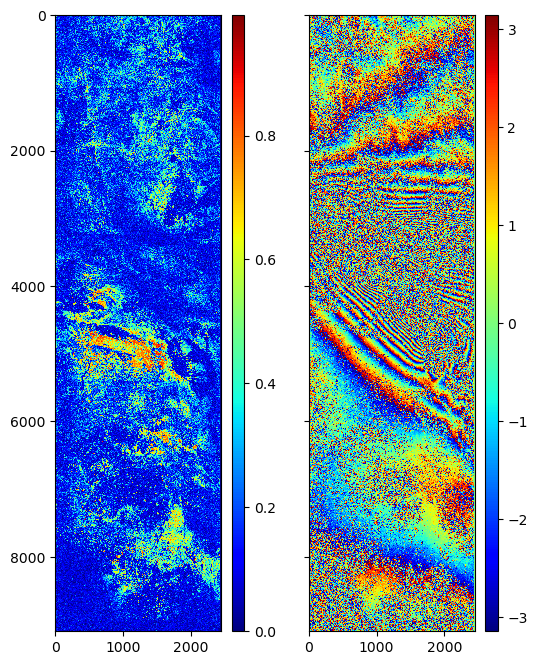

In [28]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 8], sharey=True)
for ax, data in zip(axs, [coh, pha]):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    fig.colorbar(im, ax=ax, aspect=50)
plt.show()

In [50]:
# prepare metadata
meta = dict(atr)
meta['LENGTH'] = coh.shape[0]
meta['WIDTH'] = coh.shape[1]
meta['BANDS'] = '1'
meta['DATA_TYPE'] = 'complex64'
meta['BYTE_ORDER'] = 'little-endian'
meta['FILE_TYPE'] = '.int'
meta['PROCESSOR'] = 'isce'

# prepare int data
int_data = coh * np.exp(-1j * pha)
writefile.write_isce_file(int_data, out_file=int_file, file_type='isce_int')
writefile.write_roipac_rsc(meta, int_file+'.rsc')

write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.xml
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.vrt


'/home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.rsc'

### 2. Prepare geometry

delete exsited file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5
create HDF5 file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5 with w mode
create dataset /rangeCoord         of float32    in size of (16858, 8607)        with compression=None
create dataset /azimuthCoord       of float32    in size of (16858, 8607)        with compression=None
create dataset /height             of float32    in size of (16858, 8607)        with compression=None
create dataset /incidenceAngle     of float32    in size of (16858, 8607)        with compression=None
create dataset /azimuthAngle       of float32    in size of (16858, 8607)        with compression=None
create dataset /slantRangeDistance of float32    in size of (16858, 8607)        with compression=None
finished writing to /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5
view.py /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/i

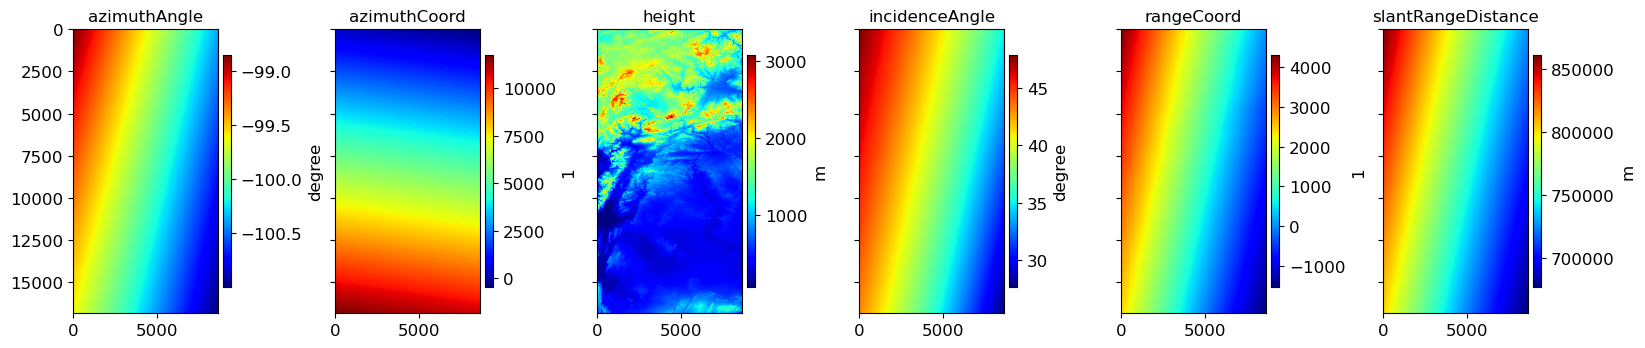

In [160]:
# read range / azimuth coordinates
lut_file = os.path.join(data_dir, 'dem/lookup_table.eqa_2_rdc')
atr = readfile.read_attribute(lut_file)
atr['BANDS'] = '2'
atr['INTERLEAVE'] = 'BIP'
atr['DATA_TYPE'] = 'float32'
atr['BYTE_ORDER'] = 'big-endian'
writefile.write_roipac_rsc(atr, lut_file+'.rsc')
rg_coord = readfile.read(lut_file, datasetName='rangeCoord')[0].astype(np.float32)
az_coord = readfile.read(lut_file, datasetName='azimuthCoord')[0].astype(np.float32)

# read height
hgt_file = os.path.join(data_dir, 'dem/SRTM_ImagePart.dem')
hgt = readfile.read(hgt_file)[0]

# read incidence / azimuth angle
inc_angle = readfile.read(os.path.join(data_dir, 'lv_theta'))[0]
az_angle = readfile.read(os.path.join(data_dir, 'lv_phi'))[0]
# convert from gamma to mintpy/isce2 convention
inc_angle = 90 - np.rad2deg(inc_angle)
az_angle = np.rad2deg(az_angle) - 90
az_angle = ut.wrap(az_angle, wrap_range=[-180, 180])

# calc slant range distance
atr = readfile.read_roipac_rsc(meta_file)
rg_dist = ut.incidence_angle2slant_range_distance(atr, inc_angle)

# write to geometryGeo.h5
ds_dict = {
    'rangeCoord'         : np.array(rg_coord, dtype=np.float32),
    'azimuthCoord'       : np.array(az_coord, dtype=np.float32),
    'height'             : np.array(hgt, dtype=np.float32),
    'incidenceAngle'     : np.array(inc_angle, dtype=np.float32),
    'azimuthAngle'       : np.array(az_angle, dtype=np.float32),
    'slantRangeDistance' : np.array(rg_dist, dtype=np.float32),
}
atr = readfile.read_attribute(lut_file)
atr['FILE_TYPE'] = 'geometry'
atr['LENGTH'] = hgt.shape[0]
atr['WIDTH'] = hgt.shape[1]
atr['DATA_TYPE'] = 'float32'
atr['BYTE_ORDER'] = 'little-endian'
for key in ['BANDS', 'INTERLEAVE']:
    if key in list(atr.keys()):
        atr.pop(key)
writefile.write(ds_dict, out_file=geom_file, metadata=atr)

# plot
view.main(f'{geom_file} --figsize 15 5 --noverbose'.split())

### 3. Estimate coherence (phase sigma)

In [31]:
isce_utils.estimate_coherence(int_file, cor_file)

GDAL open (R): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.vrt
API open (WR): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor

 << PS filtering >>


 interferogram width:  2452  number of lines/patch:  3700
 start line:        1  number of lines:    9100
 start sample:      1  end sample:         2452
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  3

 PATCH:   1   starting line:     0    lines read: 3700
 starting output line:    1   ending output line: 3568

 PATCH:   2   starting line:  3436    lines read: 3700
 starting output line:  133   ending output line: 3568

 PATCH:   3   starting line:  6872    lines read: 2228

### 4. Phase unwrap

#### 4.1 Generate mask for EQ ruptures

Go to directory: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210
read fault lat/lon from file: /home/yunjunz/data/2023TurkeyEQ/USGS/simple_fault_confident.lonlat
read fault lat/lon from file: /home/yunjunz/data/2023TurkeyEQ/USGS/simple_fault_queried.lonlat
translating lat/lon into local X/Y coordiantes...
[==================================================] fault 33/33 (8 points)    2s /     0ss 
rasterize local X/Y coordiantes with a width of 20 pixels
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk.rsc
write mask to file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk
descending orbit -> flip left-right


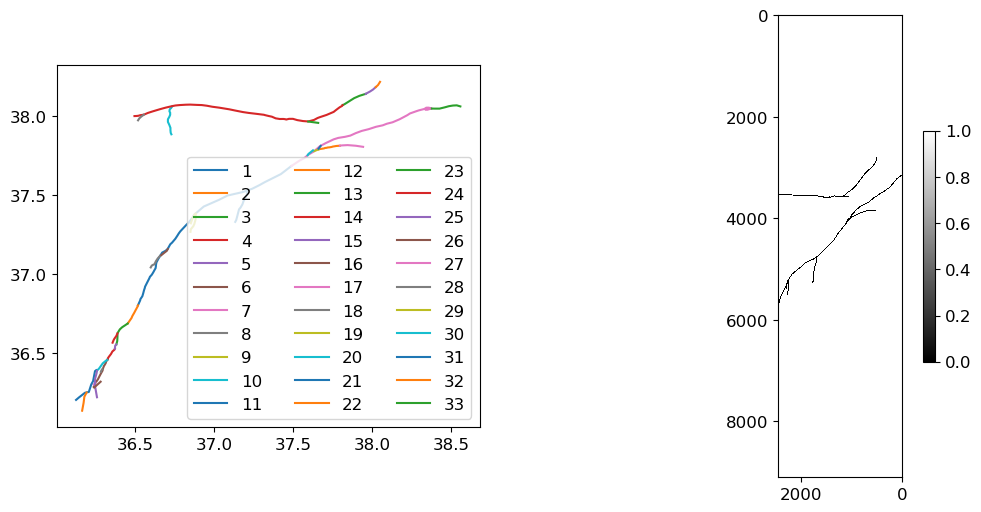

'/home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk'

In [123]:
gmt_lonlat_files = [os.path.join(proj_dir, f'USGS/simple_fault_{x}.lonlat') for x in ['confident', 'queried']]
generate_mask4earthquake_rupture(gmt_lonlat_files, int_file=int_file, msk_file=msk_file, lookup_file=geom_file, ymax=7000)

#### 4.2 Re-run `unwrap.py`

In [127]:
# prepare metadata in ROIPAC format [in addition to the existing ISCE format]
meta = readfile.read_roipac_rsc(int_file+'.rsc')
meta['BANDS'] = '2'
meta['DATA_TYPE'] = 'float32'
meta['FILE_TYPE'] = '.unw'
writefile.write_roipac_rsc(meta, unw_file+'.rsc')

# run unwrap in screen mode
print(f'cd {work_dir}')
print(f'screen -S {dname.split("_")[1]}_UNW -L\nload_insar')
cmd = f'unwrap.py -i {int_file} -c {cor_file} -o {unw_file} --mask {msk_file} '
cmd += '--comp-max 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO '
print(cmd)

cd /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210
screen -S D068_UNW -L
load_insar
unwrap.py -i /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int -c /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor -o /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.unw --mask /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk --comp-max 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO 


### 5. Mask + Geocode

In [161]:
mask.main(f'{unw_file} -m {unw_file}.conncomp'.split())

fbase = os.path.splitext(unw_file)[0]
cmd = f'{fbase}.int {fbase}.cor {fbase}_msk.unw -l {geom_file} --fill nan'
print(f'geocode.py {cmd}')
geocode.main(cmd.split())

S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
cmd = f'geo_filt_fine_msk.unw --lat {S} {N} --lon {W} {E} --outfill nan'
print(f'subset.py {cmd}')
subset.main(cmd.split())

masking magnitude from /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.unw ...
masking phase     from /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.unw ...
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine_msk.unw
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine_msk.unw.rsc
geocode.py /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine_msk.unw -l /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5 --fill nan
number of processor to be used: 1
resampling software: pyresample
output pixel size in (lat, lon) in degree: (-0.00027777778, 0.00027777778)
output area extent in (S, N, W, E) in degree: (34.800833284759996, 39.4836111, 36.2488889, 38.63972225246)
-----------------------------------------

run view.py in MintPy version 1.5.1.post44, date 2023-06-20
input file is isce .unw file: /scratch/yunjunz/2023TurkeyEQ/LT1_D068_20220411_20230210/sub_geo_filt_fine_msk.unw in float32 format
file size in y/x: (13320, 16200)
input dataset: "['phase']"
num of datasets in file sub_geo_filt_fine_msk.unw: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 16200, 13320)
subset coverage in y/x: (0, 0, 16200, 13320)
data   coverage in lat/lon: (35.00000000112, 38.99999998502, 39.50000003712, 35.29999995542)
subset coverage in lat/lon: (35.00000000112, 38.99999998502, 39.50000003712, 35.29999995542)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: LT1_D068_20220411_20230210_IFG
figure size : [9.12, 6.00]
reading data ...
Apply math operation: reverse
data    range: [-2.9431388, 0.5263772] m
di

/home/yunjunz/tools/mambaforge/envs/insar/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


showing ...


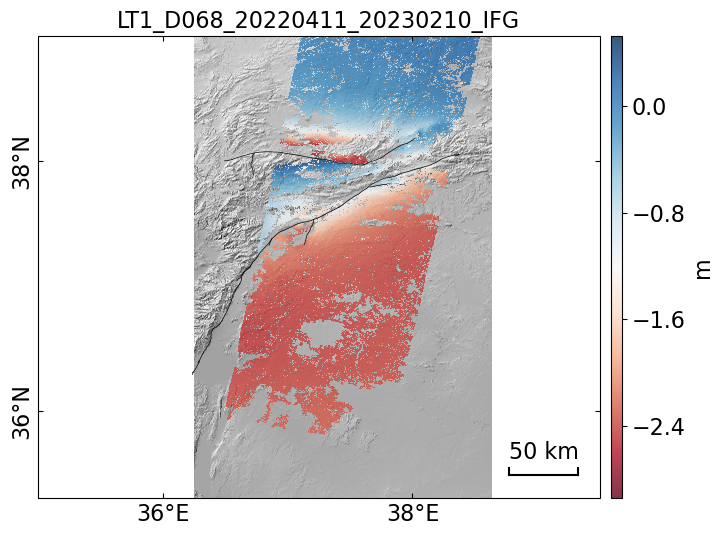

In [162]:
# plot
unw_file = 'sub_geo_filt_fine_msk.unw'
dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
out_file = os.path.join(proj_dir, f'notebooks/docs/{dname}_IFG.png')
cmd = f'{unw_file} phase --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f'-c RdBu -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --cbar-nbins 5 '
cmd += f'--scalebar 0.12 0.90 0.05 --title {dname}_IFG --ref-size 4 --math reverse '
cmd += f'-o {out_file} '
view.main(cmd.split())

### 6. Quality check + PU error correction

In [163]:
pha, atr = readfile.read('sub_geo_filt_fine_msk.unw', datasetName='phase')

ref_unw_file = os.path.join(proj_dir, 'ALOS2_D077_20220916_20230217/insar/geo/geo_filt_msk.unw')
ref_pha0, ref_atr = readfile.read(ref_unw_file, datasetName='phase')
ref_pha = resize(np.array(ref_pha0), pha.shape, order=1, mode='constant', anti_aliasing=True, preserve_range=True)

/home/yunjunz/tools/mambaforge/envs/insar/lib/python3.11/site-packages/skimage/transform/_warps.py:674: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/yunjunz/tools/mambaforge/envs/insar/lib/python3.11/site-packages/skimage/transform/_warps.py:678: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


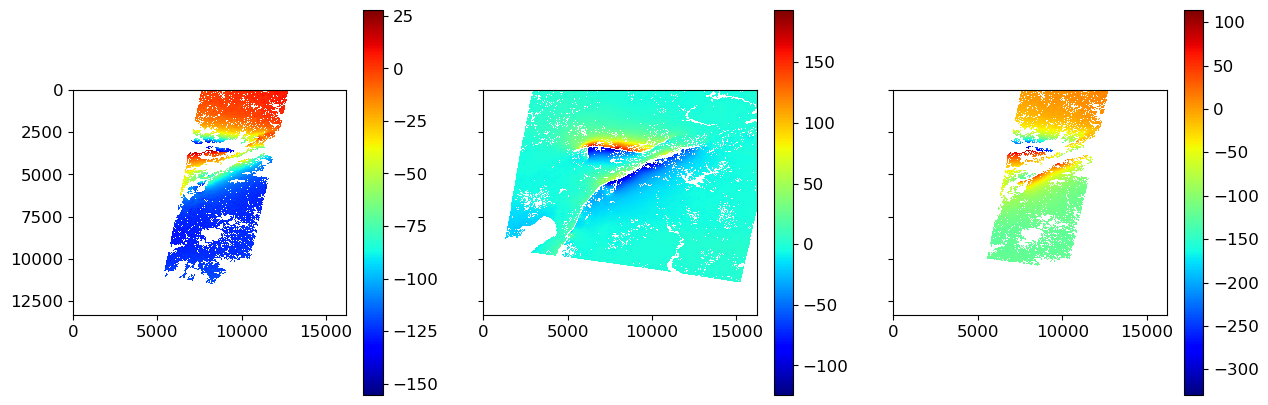

In [166]:
pha_diff = pha - ref_pha

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15,5], sharey=True)
for ax, data in zip(axs, [pha, ref_pha, pha_diff]):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    fig.colorbar(im, ax=ax)
plt.show()

### Backup: get bperp

P_BASELINE_BOTTOM_HDR: -564.51 m
P_BASELINE_TOP_HDR: -542.05 m


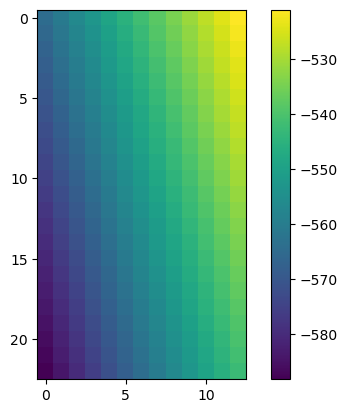

In [74]:
# read perp_baseline
bperp_file = os.path.join(data_dir, 'B_A.bperp')
num_row = int(11000 / 500 + 1)
num_col = int(2400 / 200 + 1)
bperp = np.loadtxt(bperp_file, usecols=[7], skiprows=12, max_rows=299).reshape(num_row, num_col)

print(f'P_BASELINE_BOTTOM_HDR: {np.mean(bperp[-1,:]):.2f} m')
print(f'P_BASELINE_TOP_HDR: {np.mean(bperp[0,:]):.2f} m')

# plot
plt.figure()
plt.imshow(bperp)
plt.colorbar()
plt.show()